# A Simple, Linear, Mixed-effects Model

In this book we describe the theory behind a type of statistical model called *mixed-effects* models and the practice of fitting and analyzing such models using the [`MixedModels`](https://github.com/dmbates/MixedModels.jl) package for [`Julia`](https://julialang.org). These models are used in many different disciplines. Because the descriptions of the models can vary markedly between disciplines, we begin by describing what mixed-effects models are and by exploring a very simple example of one type of mixed model, the *linear mixed model*.

This simple example allows us to illustrate the use of the `lmm` function in the `MixedModels` package for fitting such models and other functions 
for analyzing the fitted model. We also describe methods of assessing the precision of the parameter estimates and of visualizing the conditional distribution of the random effects, given the observed data.

## Mixed-effects Models

Mixed-effects models, like many other types of statistical models, describe a relationship between a *response* variable and some of the *covariates* that have been measured or observed along with the response. In mixed-effects models at least one of the covariates is a *categorical* covariate representing experimental or observational “units” in the data set. In the example from the chemical industry discussed in this chapter, the observational unit is the batch of an intermediate product used in production of a dye. In medical and social sciences the observational units are often the human or animal subjects in the study. In agriculture the experimental units may be the plots of land or the specific plants being studied.

In all of these cases the categorical covariate or covariates are observed at a set of discrete *levels*. We may use numbers, such as subject identifiers, to designate the particular levels that we observed but these numbers are simply labels. The important characteristic of a categorical covariate is that, at each observed value of the response, the covariate takes on the value of one of a set of distinct levels.

Parameters associated with the particular levels of a covariate are sometimes called the “effects” of the levels. If the set of possible levels of the covariate is fixed and reproducible we model the covariate using *fixed-effects* parameters. If the levels that we observed represent a random sample from the set of all possible levels we incorporate *random effects* in the model.

There are two things to notice about this distinction between fixed-effects parameters and random effects. First, the names are misleading because the distinction between fixed and random is more a property of the levels of the categorical covariate than a property of the effects associated with them. Secondly, we distinguish between “fixed-effects parameters”, which are indeed parameters in the statistical model, and “random effects”, which, strictly speaking, are not parameters. As we will see shortly, random effects are unobserved random variables.

To make the distinction more concrete, suppose the objective is to model the annual reading test scores for students in a school district and that the covariates recorded with the score include a student identifier and the student’s gender. Both of these are categorical covariates. The levels of the gender covariate, *male* and *female*, are fixed. If we consider data from another school district or we incorporate scores from earlier tests, we will not change those levels. On the other hand, the students whose scores we observed would generally be regarded as a sample from the set of all possible students whom we could have observed. Adding more data, either from more school districts or from results on previous or subsequent tests, will increase the number of distinct levels of the student identifier.

*Mixed-effects models* or, more simply, *mixed models* are statistical models that incorporate both fixed-effects parameters and random effects. Because of the way that we will define random effects, a model with random effects always includes at least one fixed-effects parameter. Thus, any model with random effects is a mixed model.

We characterize the statistical model in terms of two random variables: a $q$-dimensional vector of random effects represented by the random variable $\mathcal{B}$ and an $n$-dimensional response vector represented by the random variable $\mathcal{Y}$. (We use upper-case “script” characters to denote random variables. The corresponding lower-case upright letter denotes a particular value of the random variable.) We observe the value, $\bf{y}$, of $\mathcal{Y}$. We do not observe the value, $\bf{b}$, of $\mathcal{B}$.

When formulating the model we describe the unconditional distribution of $\mathcal{B}$ and the conditional distribution, $(\mathcal{Y}|\mathcal{B}=\bf{b})$. The descriptions of the distributions involve the form of the distribution and the values of certain parameters. We use the observed values of the response and the covariates to estimate these parameters and to make inferences about them.

That’s the big picture. Now let’s make this more concrete by describing a particular, versatile class of mixed models called *linear mixed models* and by studying a simple example of such a model. First we describe the data in the example.

## The `Dyestuff` and `Dyestuff2` Data

Models with random effects have been in use for a long time. The first edition of the classic book, *Statistical Methods in Research and Production*, edited by O.L. Davies, was published in 1947 and contained examples of the use of random effects to characterize batch-to-batch variability in chemical processes. The data from one of these examples are available as `Dyestuff` in the `MixedModels` package. In this section we describe and plot these data and introduce a second example, the `Dyestuff2` data, described in Box and Tiao (1973).

### The `Dyestuff` Data

The data are described in Davies (), the fourth edition of the book mentioned above, as coming from

> an investigation to find out how much the variation from batch to batch in the quality of an intermediate product (H-acid) contributes to the variation in the yield of the dyestuff (Naphthalene Black 12B) made from it. In the experiment six samples of the intermediate, representing different batches of works manufacture, were obtained, and five preparations of the dyestuff were made in the laboratory from each sample. The equivalent yield of each preparation as grams of standard colour was determined by dye-trial.

First attach the packages to be used

In [1]:
using DataFrames, Feather, Gadfly, GLM, MixedModels, RCall

The `Dyestuff` data are available in the [`lme4`](https://github.com/lme4/lme4) package for [`R`](http://r-project.org). The [`RCall`](https://github.com/JuliaStats/RCall.jl) package allows for a string prefixed with the letter `R` to be evaluated as `R` code in an embedded `R` process.  Strings in Julia are delimited by single or triple `"` characters.  If triple quotes are used the string can span several lines and, more importantly for the `RCall` package, can contain `"` characters.

In [2]:
R"""
suppressMessages(library(lme4)) # attach the lme4 package in R
print(head(Dyestuff))   # print the first few rows of Dyestuff
""";

  Batch Yield
1     A  1545
2     A  1440
3     A  1440
4     A  1520
5     A  1580
6     B  1540


In [3]:
R"""
print(summary(Dyestuff))
""";

 Batch     Yield     
 A:5   Min.   :1440  
 B:5   1st Qu.:1469  
 C:5   Median :1530  
 D:5   Mean   :1528  
 E:5   3rd Qu.:1575  
 F:5   Max.   :1635  


Although the summary does show us an important property of the data, namely that there are exactly five observations on each batch — a property that we will describe by saying that the data are *balanced* with respect to `Batch` — we usually learn much more about the structure of such data from plots than from numerical summaries.

Copy the R dataframe to Julia and plot the data.

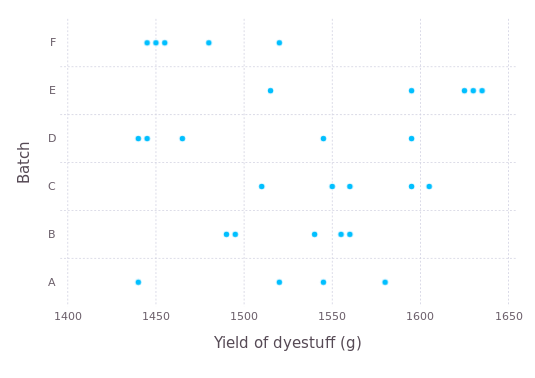

In [4]:
dyestuff = rcopy("Dyestuff");
plot(x=dyestuff[:Yield], y=convert(Vector{String}, dyestuff[:Batch]),
    Geom.point, Guide.xlabel("Yield of dyestuff (g)"), Guide.ylabel("Batch"))

In the dotplot we can see that there is considerable variability in yield, even for preparations from the same batch, but there is also noticeable batch-to-batch variability. For example, four of the five preparations from batch F provided lower yields than did any of the preparations from batches C and E.

Recall that the labels for the batches are just labels and that their ordering is arbitrary.  In a plot, however, the order of the levels influences the perception of the pattern.  Rather than providing an arbitrary pattern it is best to order the levels according to some criterion for the plot.  In this case a good choice is to order the batches by increasing mean yield, which can be easily done in R.

(Note: at present this plot fails because of the ongoing DataFrames conversion.)

In [5]:
#dyestuff = rcopy("within(Dyestuff, Batch <- reorder(Batch, Yield, mean))");
#plot(dyestuff, x="Yield", y="Batch", Geom.point, Guide.xlabel("Yield of dyestuff (g)"))

In Sect. [sec:DyestuffLMM] we will use mixed models to quantify the variability in yield between batches. For the time being let us just note that the particular batches used in this experiment are a selection or sample from the set of all batches that we wish to consider. Furthermore, the extent to which one particular batch tends to increase or decrease the mean yield of the process — in other words, the “effect” of that particular batch on the yield — is not as interesting to us as is the extent of the variability between batches. For the purposes of designing, monitoring and controlling a process we want to predict the yield from future batches, taking into account the batch-to-batch variability and the within-batch variability. Being able to estimate the extent to which a particular batch in the past increased or decreased the yield is not usually an important goal for us. We will model the effects of the batches as random effects rather than as fixed-effects parameters.

### The `Dyestuff2` Data

The data are simulated data presented in Box and Tiao (1973), where the authors state

> These data had to be constructed for although examples of this sort undoubtedly occur in practice they seem to be rarely published.

The structure and summary

In [6]:
R"print(str(Dyestuff2))";

'data.frame':	30 obs. of  2 variables:
 $ Batch: Factor w/ 6 levels "A","B","C","D",..: 1 1 1 1 1 2 2 2 2 2 ...
 $ Yield: num  7.3 3.85 2.43 9.57 7.99 ...
NULL


In [7]:
R"print(summary(Dyestuff2))";

 Batch     Yield       
 A:5   Min.   :-0.892  
 B:5   1st Qu.: 2.765  
 C:5   Median : 5.365  
 D:5   Mean   : 5.666  
 E:5   3rd Qu.: 8.151  
 F:5   Max.   :13.434  


are intentionally similar to those of the `Dyestuff` data. As can be seen in Fig. [fig:Dyestuff2dot]

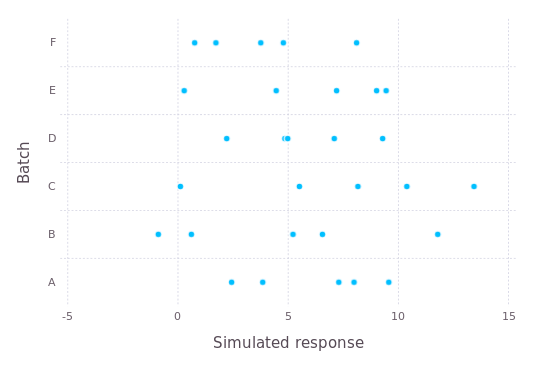

In [8]:
dyestuff2 = rcopy("Dyestuff2");
plot(x=dyestuff2[:Yield], y=convert(Vector{String}, dyestuff2[:Batch]),
Geom.point, Guide.xlabel("Simulated response"), Guide.ylabel("Batch"))

the batch-to-batch variability in these data is small compared to the within-batch variability. In some approaches to mixed models it can be difficult to fit models to such data. Paradoxically, small “variance components” can be more difficult to estimate than large variance components.

The methods we will present are not compromised when estimating small variance components.

## Fitting Linear Mixed Models

Before we formally define a linear mixed model, let’s go ahead and fit models to these data sets using `lmm` which takes, as its first two arguments, a *formula* specifying the model and the *data* with which to evaluate the formula. 

The structure of the formula will be explained after showing the example.

### A Model For the `Dyestuff` Data

A model allowing for an overall level of the `Yield` and for an additive random effect for each level of `Batch` can be fit as

In [9]:
mm1 = fit!(lmm(Yield ~ 1 + (1 | Batch), dyestuff))

Linear mixed model fit by maximum likelihood
 Formula: Yield ~ 1 + (1 | Batch)
  logLik    -2 logLik     AIC        BIC    
 -163.66353  327.32706  333.32706  337.53065

Variance components:
              Column    Variance  Std.Dev. 
 Batch    (Intercept)  1388.3334 37.260346
 Residual              2451.2500 49.510100
 Number of obs: 30; levels of grouping factors: 6

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)    1527.5   17.6946  86.326  <1e-99


As shown in the summary of the model fit, the default estimation criterion is maximum likelihood.  The summary provides several other model-fit statistics such as Akaike’s Information Criterion (`AIC`), Schwarz’s Bayesian Information Criterion (`BIC`), the log-likelihood at the parameter estimates, and the objective function (negative twice the log-likelihood) at the parameter estimates. These are all statistics related to the model fit and are used to compare different models fit to the same data.

The third section is the table of estimates of parameters associated with the random effects. There are two sources of variability in this model, a batch-to-batch variability in the level of the response and the residual or per-observation variability — also called the within-batch variability. The name “residual” is used in statistical modeling to denote the part of the variability that cannot be explained or modeled with the other terms. It is the variation in the observed data that is “left over” after determining the estimates of the parameters in the other parts of the model.

Some of the variability in the response is associated with the fixed-effects terms. In this model there is only one such term, labeled the `(Intercept)`. The name “intercept”, which is better suited to models based on straight lines written in a slope/intercept form, should be understood to represent an overall “typical” or mean level of the response in this case. (For those wondering about the parentheses around the name, they are included so that a user cannot accidentally name a variable in conflict with this name.) The line labeled `Batch` in the random effects table shows that the random effects added to the intercept term, one for each level of the factor, are modeled as random variables whose unconditional variance is estimated as 1388.33 g$^2$. The corresponding standard deviations is 37.26 g for the ML fit.

Note that the last column in the random effects summary table is the estimate of the variability expressed as a standard deviation rather than as a variance. These are provided because it is usually easier to visualize the variability in standard deviations, which are on the scale of the response, than it is to visualize the magnitude of a variance. The values in this column are a simple re-expression (the square root) of the estimated variances. Do not confuse them with the standard errors of the variance estimators, which are not given here. As described in later sections, standard errors of variance estimates are generally not useful because the distribution of the estimator of a variance is skewed - often badly skewed.

The line labeled `Residual` in this table gives the estimate, 2451.25 g$^2$, of the variance of the residuals and the corresponding standard deviation, 49.51 g. In written descriptions of the model the residual variance parameter is written $\sigma^2$ and the variance of the random effects is $\sigma_1^2$.  Their estimates are $\widehat{\sigma^2}$ and $\widehat{\sigma_1^2}$

The last line in the random effects table states the number of observations to which the model was fit and the number of levels of any “grouping factors” for the random effects. In this case we have a single random effects term, `(1 | Batch)`, in the model formula and the grouping factor for that term is `Batch`. There will be a total of six random effects, one for each level of `Batch`.

The final part of the printed display gives the estimates and standard errors of any fixed-effects parameters in the model. The only fixed-effects term in the model formula is the `(Intercept)`. The estimate of this parameter is 1527.5 g. The standard error of the intercept estimate is 17.69 g.

### A Model For the `Dyestuff2` Data

Fitting a similar model to the `dyestuff2` data produces an estimate $\widehat{\sigma_1^2}=0$.

In [10]:
mm2 = fit!(lmm(Yield ~ 1 + (1 | Batch), dyestuff2))

Linear mixed model fit by maximum likelihood
 Formula: Yield ~ 1 + (1 | Batch)
  logLik    -2 logLik     AIC        BIC    
 -81.436518 162.873037 168.873037 173.076629

Variance components:
              Column    Variance  Std.Dev. 
 Batch    (Intercept)   0.000000 0.0000000
 Residual              13.346099 3.6532314
 Number of obs: 30; levels of grouping factors: 6

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)    5.6656  0.666986 8.49433  <1e-16


An estimate of `0` for $\sigma_1$ does not mean that there is no variation between the groups. Indeed Fig. [fig:Dyestuff2dot] shows that there is some small amount of variability between the groups. The estimate, $\widehat{\sigma_1}$, is a measure of the “between-group” variability that is **in excess of** the variability induced by the "within-group" or residual variability in the responses.  

If 30 observations were simulated from a "normal" (also called "Gaussian") distribution and divided arbitrarily into 6 groups of 5, a plot of the data would look very much like Fig. [fig:Dyestuff2dot].  (In fact, it is likely that this is how that data set was generated.) It is only where there is excess variability between the groups that $\widehat{\sigma_1}>0$.  Obtaining $\widehat{\sigma_1}=0$ is not a mistake; it is simply a statement about the data and the model.

The important point to take away from this example is the need to allow for the estimates of variance components that are zero. Such a model is said to be *singular*, in the sense that it corresponds to a linear model in which we have removed the random effects associated with `Batch`. Singular models can and do occur in practice. Even when the final fitted model is not singular, we must allow for such models to be expressed when determining the parameter estimates through numerical optimization.

It happens that this model corresponds to the linear model (i.e. a model with fixed-effects only)

In [11]:
lm1 = lm(Yield ~ 1, dyestuff2)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredQR{Float64}},Array{Float64,2}}

Formula: Yield ~ +1

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)    5.6656  0.678388 8.35156    <1e-8


The log-likelihood for this model

In [12]:
loglikelihood(lm1)

-81.43651832691287

is the same as that of `fm2`.  The standard error of the intercept in `lm1` is a bit larger than that of `fm2` because the estimate of the residual variance is evaluated differently in the linear model.

### Further Assessment of the Fitted Models

The parameter estimates in a statistical model represent our “best guess” at the unknown values of the model parameters and, as such, are important results in statistical modeling. However, they are not the whole story. Statistical models characterize the variability in the data and we must assess the effect of this variability on the parameter estimates and on the precision of predictions made from the model.

In Sect. [sec:variability] we introduce a method of assessing variability in parameter estimates using the “profiled log-likelihood” and in Sect. [sec:assessRE] we show methods of characterizing the conditional distribution of the random effects given the data. Before we get to these sections, however, we should state in some detail the probability model for linear mixed-effects and establish some definitions and notation. In particular, before we can discuss profiling the log-likelihood, we should define the log-likelihood. We do that in the next section.

## The Linear Mixed-effects Probability Model

In explaining some of parameter estimates related to the random effects we have used terms such as “unconditional distribution” from the theory of probability. Before proceeding further we clarify the linear mixed-effects probability model and define several terms and concepts that will be used throughout the book. Readers who are more interested in practical results than in the statistical theory should feel free to skip this section.

### Definitions and Results

In this section we provide some definitions and formulas without derivation and with minimal explanation, so that we can use these terms in what follows. In Chap. [chap:computational] we revisit these definitions providing derivations and more explanation.

As mentioned in Sect. [sec:memod], a mixed model incorporates two random variables: $\mathcal{B}$, the $q$-dimensional vector of random effects, and $\mathcal{Y}$, the $n$-dimensional response vector. In a linear mixed model the unconditional distribution of $\mathcal{B}$ and the conditional distribution, $(\mathcal{Y} | \mathcal{B}=\bf{b})$, are both multivariate Gaussian distributions,

\begin{aligned}
  (\mathcal{Y} | \mathcal{B}=\bf{b}) &\sim\mathcal{N}(\bf{ X\beta + Z b},\sigma^2\bf{I})\\
  \mathcal{B}&\sim\mathcal{N}(\bf{0},\Sigma_\theta) .
\end{aligned}

The *conditional mean* of $\mathcal Y$, given $\mathcal B=\bf b$, is the *linear predictor*, $\bf X\bf\beta+\bf Z\bf b$, which depends on the $p$-dimensional *fixed-effects parameter*, $\bf \beta$, and on $\bf b$. The *model matrices*, $\bf X$ and $\bf Z$, of dimension $n\times p$ and $n\times q$, respectively, are determined from the formula for the model and the values of covariates. Although the matrix $\bf Z$ can be large (i.e. both $n$ and $q$ can be large), it is sparse (i.e. most of the elements in the matrix are zero).

The *relative covariance factor*, $\Lambda_\theta$, is a $q\times q$ lower-triangular matrix, depending on the *variance-component parameter*, $\bf\theta$, and generating the symmetric $q\times q$ variance-covariance matrix, $\Sigma_\theta$, as

\begin{equation}
  \Sigma_\theta=\sigma^2\Lambda_\theta\Lambda_\theta'
\end{equation}

The *spherical random effects*, $\mathcal{U}\sim\mathcal{N}({\bf 0},\sigma^2{\bf I}_q)$, determine $\mathcal B$ according to

\begin{equation}
  \mathcal{B}=\Lambda_\theta\mathcal{U}$.
\end{equation}

The *penalized residual sum of squares* (PRSS),

\begin{equation}
  r^2(\bf\theta,\bf\beta,\bf u)=\|\bf y -\bf X\bf\beta -\bf Z\Lambda_\theta\bf u\|^2+\|\bf u\|^2,
\end{equation}

is the sum of the residual sum of squares, measuring fidelity of the model to the data, and a penalty on the size of $\bf u$, measuring the complexity of the model. Minimizing $r^2$ with respect to $\bf u$,

\begin{equation}
  r^2_{\beta,\theta} =\min_{\bf u}\left\{\|{\bf y} -{\bf X}{\bf\beta} -{\bf Z}\Lambda_\theta{\bf u}\|^2+\|{\bf u}\|^2\right\}
\end{equation}

is a direct (i.e. non-iterative) computation.  The particular method used to solve this generates a *blocked Choleksy factor*, $\bf{R}_\theta$, which is an upper triangular $q\times q$ matrix satisfying

\begin{equation}
  \bf R_\theta'\bf R_\theta=\Lambda_\theta'\bf Z'\bf Z\Lambda_\theta+\bf I_q .
\end{equation}

where $\bf I_q$ is the $q\times q$ *identity matrix*.

Negative twice the log-likelihood of the parameters, given the data, $\bf y$, is

\begin{equation}
d({\bf\theta},{\bf\beta},\sigma|{\bf y})
=n\log(2\pi\sigma^2)+\log(|{\bf R}_\theta|^2)+\frac{r^2_{\beta,\theta}}{\sigma^2}.
\end{equation}

where $|{\bf R}_\theta|$ denotes the *determinant* of ${\bf R}_\theta$. Because ${\bf R}_\theta$ is triangular, its determinant is the product of its diagonal elements.

Negative twice the log-likelihood will be called the *objective* in what follows.  It is the value to be minimized by the parameter estimates.  It is, up to an additive factor, the *deviance* of the parameters.  Unfortunately, it is not clear what the additive factor should be in the case of linear mixed models.  In many applications, however, it is not the deviance of the model that is of interest as much the change in the deviance between two fitted models.  When calculating the change in the deviance the additive factor will cancel out so the change in the deviance when comparing models is the same as the change in this objective.

Because the conditional mean, $\bf\mu_{\mathcal Y|\mathcal B=\bf b}=\bf
X\bf\beta+\bf Z\Lambda_\theta\bf u$, is a linear function of both $\bf\beta$ and $\bf u$, minimization of the PRSS with respect to both $\bf\beta$ and $\bf u$ to produce

\begin{equation}
r^2_\theta =\min_{{\bf\beta},{\bf u}}\left\{\|{\bf y} -{\bf X}{\bf\beta} -{\bf Z}\Lambda_\theta{\bf u}\|^2+\|{\bf u}\|^2\right\}
\end{equation}

is also a direct calculation. The values of $\bf u$ and $\bf\beta$ that provide this minimum are called, respectively, the *conditional mode*, $\tilde{\bf u}_\theta$, of the spherical random effects and the conditional estimate, $\widehat{\bf\beta}_\theta$, of the fixed effects. At the conditional estimate of the fixed effects the objective is

\begin{equation}
d({\bf\theta},\widehat{\beta}_\theta,\sigma|{\bf y})
=n\log(2\pi\sigma^2)+\log(|{\bf L}_\theta|^2)+\frac{r^2_\theta}{\sigma^2}.
\end{equation}

Minimizing this expression with respect to $\sigma^2$ produces the conditional estimate

\begin{equation}
\widehat{\sigma^2}_\theta=\frac{r^2_\theta}{n}
\end{equation}

which provides the *profiled log-likelihood* on the deviance scale as

\begin{equation}
\tilde{d}(\bf\theta|\bf y)=d(\bf\theta,\widehat{\beta}_\theta,\widehat{\sigma}_\theta|\bf y)
=\log(|\bf R_\theta|^2)+n\left[1+\log\left(\frac{2\pi r^2_\theta}{n}\right)\right],
\end{equation}

a function of $\bf\theta$ alone.

The MLE of $\bf\theta$, written $\widehat{\bf\theta}$, is the value that minimizes this profiled objective. We determine this value by numerical optimization. In the process of evaluating $\tilde{d}(\widehat{\bf\theta}|{\bf y})$ we determine $\widehat{\bf\beta}=\widehat{\bf\beta}_{\widehat\theta}$, $\tilde{\bf u}_{\widehat{\theta}}$ and $r^2_{\widehat{\theta}}$, from which we can evaluate $\widehat{\sigma}=\sqrt{r^2_{\widehat{\theta}}/n}$.

The elements of the conditional mode of $\mathcal B$, evaluated at the parameter estimates,

\begin{equation}
\tilde{\bf b}_{\widehat{\theta}}=
\Lambda_{\widehat{\theta}}\tilde{\bf u}_{\widehat{\theta}}
\end{equation}

are sometimes called the *best linear unbiased predictors* or BLUPs of the random effects. Although BLUPs an appealing acronym, I don’t find the term particularly instructive (what is a “linear unbiased predictor” and in what sense are these the “best”?) and prefer the term “conditional modes”, because these are the values of $\bf b$ that maximize the density of the conditional distribution $(\mathcal{B} | \mathcal{Y} = {\bf y}$.  For a linear mixed model, where all the conditional and unconditional distributions are Gaussian, these values are also the *conditional means*.

### Fields of a `LinearMixedModel` object

The optional second argument, `verbose`, in a call to `fit!` of a `LinearMixedModel` object produces output showing the progress of the iterative optimization of $\tilde{d}(\bf\theta|\bf y)$.

In [13]:
mm1 = fit!(lmm(Yield ~ 1 + (1 | Batch), dyestuff), true);

f_1: 327.76702 [1.0]
f_2: 331.03619 [1.75]
f_3: 330.64583 [0.25]
f_4: 327.69511 [0.97619]
f_5: 327.56631 [0.928569]
f_6: 327.3826 [0.833327]
f_7: 327.35315 [0.807188]
f_8: 327.34663 [0.799688]
f_9: 327.341 [0.792188]
f_10: 327.33253 [0.777188]
f_11: 327.32733 [0.747188]
f_12: 327.32862 [0.739688]
f_13: 327.32706 [0.752777]
f_14: 327.32707 [0.753527]
f_15: 327.32706 [0.752584]
f_16: 327.32706 [0.752509]
f_17: 327.32706 [0.752591]
f_18: 327.32706 [0.752581]


The algorithm converges after 18 function evaluations to a profiled deviance of 327.32706 at $\theta=0.752581$. In this model the parameter $\theta$ is of length 1, the single element being the ratio $\sigma_1/\sigma$.

Whether or not verbose output is requested, the `optsum` field of a `LinearMixedModel` contains information on the optimization.  The various tolerances or the optimizer name can be changed between creating a `LinearMixedModel` and calling `fit!` on it to exert finer control on the optimization process.

In [14]:
mm1.optsum

Initial parameter vector: [1.0]
Initial objective value:  327.76702162461663

Optimizer (from NLopt):   LN_BOBYQA
Lower bounds:             [0.0]
ftol_rel:                 1.0e-12
ftol_abs:                 1.0e-8
xtol_rel:                 0.0
xtol_abs:                 [1.0e-10]

Function evaluations:     18
Final parameter vector:   [0.752581]
Final objective value:    327.32705988113645
Return code:              FTOL_REACHED


The full list of fields in a `LinearMixedModel` object is

In [15]:
fieldnames(LinearMixedModel)

9-element Array{Symbol,1}:
 :formula
 :mf     
 :wttrms 
 :trms   
 :sqrtwts
 :Λ      
 :A      
 :R      
 :optsum 

The `formula` field is a copy of the model formula

In [16]:
mm1.formula

Formula: Yield ~ 1 + (1 | Batch)

The `mf` field is a `ModelFrame` constructed from the `formula` and `data` arguments to `lmm`.  It contains a `DataFrame` formed by reducing the `data` argument to only those columns needed to evaluate the `formula` and only those rows that have no missing data.  It also contains information on the terms in the model formula and on any "contrasts" associated with categorical variables in the fixed-effects terms.

The `trms` field is a vector of numerical objects representing the terms in the model, including the response vector.  As the names imply, the `sqrtwts` and `wttrms` fields are for incorporating case weights.  These fields are not often used when fitting linear mixed models but are vital to the process of fitting a generalized linear mixed model, described in Chapter [sec:glmm].  When used, `sqrtwts` is a diagonal matrix of size `n`. A size of `0` indicates weights are not used.

In [17]:
mm1.sqrtwts

0×0 Diagonal{Float64}

The `trms` field is a vector of length $\ge 3$.

In [18]:
length(mm1.trms)

3

The last two elements are $\bf X$, the $n\times p$ model matrix for the fixed-effects parameters, $\bf\beta$, and $\bf y$, the response vector stored as a matrix of size $n\times 1$.  In `mm1`, $\bf X$ consists of a single column of 1's

In [19]:
mm1.trms[end - 1]

30×1 Array{Float64,2}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [20]:
mm1.trms[end]

30×1 Array{Float64,2}:
 1545.0
 1440.0
 1440.0
 1520.0
 1580.0
 1540.0
 1555.0
 1490.0
 1560.0
 1495.0
 1595.0
 1550.0
 1605.0
    ⋮  
 1465.0
 1545.0
 1595.0
 1630.0
 1515.0
 1635.0
 1625.0
 1520.0
 1455.0
 1450.0
 1480.0
 1445.0

The elements of `trms` before the last two represent vertical sections of $\bf Z$ associated with the random effects terms in the model.  In `mm1` there is only one random effects term, `(1 | Batch)`, and $\bf Z$ has only one section, the one generated by this term, of type `ScalarReMat`.

In [21]:
mm1.trms[1]

MixedModels.ScalarReMat{Float64,String,UInt32}(CategoricalArrays.CategoricalValue{String,UInt32}["A","A","A","A","A","B","B","B","B","B"  …  "E","E","E","E","E","F","F","F","F","F"],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],:Batch,String["(Intercept)"])

In practice these matrices are stored in a highly condensed form because, in some models, they can be very large. In small examples the structure is more obvious when the `ScalarReMat` is converted to a sparse or a dense matrix.

In [22]:
sparse(mm1.trms[1])

30×6 sparse matrix with 30 Float64 nonzero entries:
	[1 ,  1]  =  1.0
	[2 ,  1]  =  1.0
	[3 ,  1]  =  1.0
	[4 ,  1]  =  1.0
	[5 ,  1]  =  1.0
	[6 ,  2]  =  1.0
	[7 ,  2]  =  1.0
	[8 ,  2]  =  1.0
	[9 ,  2]  =  1.0
	[10,  2]  =  1.0
	⋮
	[20,  4]  =  1.0
	[21,  5]  =  1.0
	[22,  5]  =  1.0
	[23,  5]  =  1.0
	[24,  5]  =  1.0
	[25,  5]  =  1.0
	[26,  6]  =  1.0
	[27,  6]  =  1.0
	[28,  6]  =  1.0
	[29,  6]  =  1.0
	[30,  6]  =  1.0

In [23]:
full(mm1.trms[1])

30×6 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 ⋮                        ⋮  
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0

The `A` field is a representation of the blocked, square, symmetric matrix $\bf A = [Z : X : y]'[Z : X : y]$.  Only the upper triangle of `A` is stored.  The number of blocks of the rows and columns of `A` is the number of vertical sections of $\bf Z$ (i.e. the number of random-effects terms) plus 2.

In [25]:
size(mm1.A)

(3,3)

In [26]:
mm1.A[1, 1]

6×6 Diagonal{Float64}:
 5.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   5.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   5.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   5.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   5.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   5.0

In [27]:
mm1.A[1, 2]

6×1 Array{Float64,2}:
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0

In [28]:
mm1.A[2,2]

1×1 Array{Float64,2}:
 30.0

In [29]:
mm1.A[1,3]

6×1 Array{Float64,2}:
 7525.0
 7640.0
 7820.0
 7490.0
 8000.0
 7350.0

In [30]:
mm1.A[2, 3]

1×1 Array{Float64,2}:
 45825.0

In [31]:
mm1.A[3, 3]

1×1 Array{Float64,2}:
 7.01129e7

## Fields modified during the optimization

Changing the value of $\theta$ changes the $\Lambda$ field.  (Note: to input a symbol like $\Lambda$ in a Jupyter code cell or in the Julia read-eval-print loop (REPL), type `\Lambda` followed by a tab character.  Such "latex completions" are available for many UTF-8 characters used in Julia.)  The matrix $\Lambda$ has a special structure.  It is a block diagonal matrix where the diagonal blocks are [`Kronecker product`](https://en.wikipedia.org/wiki/Kronecker_product)s of an identity matrix and a (small) lower triangular matrix.  The diagonal blocks correspond to the random-effects terms.  For a scalar random-effects term, like `(1 | Batch)` the diagonal block is the Kronecker product of an identity matrix and a $1\times 1$ matrix which is simply a multiple of the identity matrix.

It is not necessary to store the full $\Lambda$ matrix.  Storing the small lower-triangular matrices is sufficient.

In [32]:
mm1.Λ

1-element Array{LowerTriangular{Float64,Array{Float64,2}},1}:
 [0.752581]

The `R` field is a blocked matrix like the `A` field containing the upper Cholesky factor of

\begin{bmatrix}
  \bf{\Lambda'Z'Z\Lambda + I} & \bf{\Lambda'Z'X} & \bf{\Lambda'Z'y} \\
  \bf{X'Z\Lambda} & \bf{X'X} & \bf{X'y} \\
  \bf{y'Z\Lambda} & \bf{y'Z} & \bf{y'y}
\end{bmatrix}   

In [33]:
mm1.R[1, 1]

6×6 Diagonal{Float64}:
 1.95752   ⋅        ⋅        ⋅        ⋅        ⋅     
  ⋅       1.95752   ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅       1.95752   ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅       1.95752   ⋅        ⋅     
  ⋅        ⋅        ⋅        ⋅       1.95752   ⋅     
  ⋅        ⋅        ⋅        ⋅        ⋅       1.95752

In [34]:
mm1.R[1, 2]

6×1 Array{Float64,2}:
 1.92228
 1.92228
 1.92228
 1.92228
 1.92228
 1.92228

In [35]:
mm1.R[2, 2]

1×1 Array{Float64,2}:
 2.79804

In [36]:
mm1.R[1, 3]

6×1 Array{Float64,2}:
 2893.03
 2937.24
 3006.45
 2879.58
 3075.65
 2825.75

In [39]:
mm1.R[2, 3]

1×1 Array{Float64,2}:
 4274.01

In [40]:
mm1.R[3, 3]

1×1 Array{Float64,2}:
 271.178

All the information needed to evaluate the profiled log-likelihood is available in the `R` field; $\log(|\bf R_\theta|^2)$ is

In [42]:
2 * sum(log.(diag(mm1.R[1,1])))

8.060146776142005

It can also be evaluated as `logdet(mm1)` or `2 * logdet(mm1.R[1, 1])`

In [46]:
logdet(mm1) == (2 * logdet(mm1.R[1, 1])) == 
    (2 * sum(log.(diag(mm1.R[1, 1]))))

true

The penalized residual sum of squares is the square of the single element of the lower-right block, `R[3, 3]` in this case

In [47]:
abs2(mm1.R[3, 3][1, 1])

73537.49947885796

In [48]:
pwrss(mm1)

73537.49947885796

The objective is

In [49]:
logdet(mm1) + nobs(mm1) * (1 + log(2π * pwrss(mm1) / nobs(mm1)))

327.32705988113645

## Assessing variability of parameter estimates

One way to assess the variability of the parameter estimates is to generate a parametric bootstrap sample from the model.  The technique is to simulate response vectors from the model at the estimated parameter values and refit the model to each of these simulated responses, recording the values of the parameters.  The `bootstrap` method for these models performs these simulations and returns 4 arrays: a vector of objective (negative twice the log-likelihood) values, a vector of estimates of $\sigma^2$, a matrix of estimates of the fixed-effects parameters and a matrix of the estimates of the relative covariance parameters.  In this case there is only one fixed-effects parameter and one relative covariance parameter, which is the ratio of the standard deviation of the random effects to the standard deviation of the per-sample noise.

In [ ]:
obj1, s21, beta1, theta1 = bootstrap(10000, fm1);
plot(x = beta1, Geom.density, Guide.xlabel("Bootstrap samples of β₁ from fm1"))

In [ ]:
plot(x = s21, Geom.density, Guide.xlabel("Bootstrap samples of σ² from fm1"))

In [ ]:
plot(x = s21 .* vec(abs2.(theta1)), Geom.density, Guide.xlabel("Bootstrap samples of σ₁² from fm1"))

The last two density plots show that, even if the models are defined in terms of variances, the variance is usually not a good scale on which to assess the variability of the parameter estimates.  The standard deviation or, in some cases, the logarithm of the standard deviation is a more suitable scale.

In [ ]:
s1 = sqrt.(s21);
plot(x = s1, Geom.density, Guide.xlabel("Bootstrap samples of σ from fm1"))

In [ ]:
plot(x = s1 .* vec(theta1), Geom.density, Guide.xlabel("Bootstrap samples of σ₁ from fm1"))

The spike at zero on the density plot of $\sigma_1$ shows up more clearly in a histogram.

In [ ]:
plot(x = s1 .* vec(theta1), Geom.histogram, Guide.xlabel("Bootstrap samples of σ₁ from fm1"))

Over 1000 of the 10,000 simulations resulted in a zero estimate of $\sigma_1$.  Instead of counting the number of times that the estimate of $\theta=\sigma_1/\sigma$ is exactly zero

In [ ]:
sum(x -> x == 0, theta1)

it is best to count the number of times that it is very small

In [ ]:
issmall(x) = x < 0.00001
sum(issmall, theta1)

The third section is the table of estimates of parameters associated with the random effects. There are two sources of variability in the model we have fit, a batch-to-batch variability in the level of the response and the residual or per-observation variability — also called the within-batch variability. The name “residual” is used in statistical modeling to denote the part of the variability that cannot be explained or modeled with the other terms. It is the variation in the observed data that is “left over” after we have determined the estimates of the parameters in the other parts of the model.

Some of the variability in the response is associated with the fixed-effects terms. In this model there is only one such term, labeled as the `(Intercept)`. The name “intercept”, which is better suited to models based on straight lines written in a slope/intercept form, should be understood to represent an overall “typical” or mean level of the response in this case. (In case you are wondering about the parentheses around the name, they are included so that you cannot accidentally create a variable with a name that conflicts with this name.) The line labeled `Batch` in the random effects table shows that the random effects added to the term, one for each level of the factor, are modeled as random variables whose unconditional variance is estimated as 1764.05 g$^2$ in the REML fit and as 1388.33 g$^2$ in the ML fit. The corresponding standard deviations are 42.00 g for the REML fit and 37.26 g for the ML fit.

Note that the last column in the random effects summary table is the estimate of the variability expressed as a standard deviation rather than as a variance. These are provided because it is usually easier to visualize standard deviations, which are on the scale of the response, than it is to visualize the magnitude of a variance. The values in this column are a simple re-expression (the square root) of the estimated variances. Do not confuse them with the standard errors of the variance estimators, which are not given here. In Sect. [sec:variability] we explain why we do not provide standard errors of variance estimates.

The line labeled in this table gives the estimate of the variance of the residuals (also in g$^2$) and its corresponding standard deviation. For the REML fit the estimated standard deviation of the residuals is 49.51 g and for the ML fit it is also 49.51 g. (Generally these estimates do not need to be equal. They happen to be equal in this case because of the simple model form and the balanced data set.)

The last line in the random effects table states the number of observations to which the model was fit and the number of levels of any “grouping factors” for the random effects. In this case we have a single random effects term, , in the model formula and the grouping factor for that term is . There will be a total of six random effects, one for each level of .

The final part of the printed display gives the estimates and standard errors of any fixed-effects parameters in the model. The only fixed-effects term in the model formula is the , denoting a constant which, as explained above, is labeled as . For both the REML and the ML estimation criterion the estimate of this parameter is 1527.5 g (equality is again a consequence of the simple model and balanced data set). The standard error of the intercept estimate is 19.38 g for the REML fit and 17.69 g for the ML fit.

### A Model For the `Dyestuff2` Data

Fitting a similar model to the data produces an estimate $\widehat{\sigma}_1=0$ in both the REML